In [1]:
%load_ext autoreload
%autoreload 2

from typing import Tuple

import numpy as np
import tensorflow as tf

from PIL import Image
from pathlib import Path

import matplotlib.pyplot as plt

from dataloader.data_generator import DataGenerator
from dataloader.ds_pairs import get_pairwise_dataset
from models.feature_model import IMAGE_SIZE_EFFICIENTNET
from models.image_matcher import ImageMatcher
from train import DATA_DIRPATH, BATCH_SIZE, IMAGE_SIZE_DATASET, VALIDATION_SPLIT
from utils.helper import load_config


CONFIG_FILEPATH = "config.yaml"

# Create an instance of `ImageMatcher`

In [2]:
image_matcher = ImageMatcher(model_filepath="saved_models/efficientnet/")

image_matcher.model.summary()

2022-12-28 19:01:11.752132: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-28 19:01:11.752261: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "image_matching"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 224, 224  0           []                               
                                , 3)]                                                             
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 224, 224, 3)  0          ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 224, 224, 3)  0          ['input_1[0][0]']                
 icingOpLambda)                                        

# Verify that the embeddings accurately discriminate different classes of images

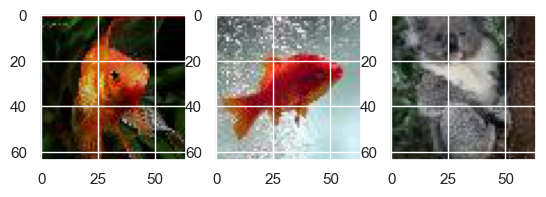

In [3]:
list_img_filepaths = [
    "tiny-imagenet-200/train/n01443537/images/n01443537_4.JPEG",
    "tiny-imagenet-200/train/n01443537/images/n01443537_10.JPEG",
    "tiny-imagenet-200/train/n01882714/images/n01882714_2.JPEG"
]

with Image.open(list_img_filepaths[0]) as im:
    im_1 = np.array(im)

with Image.open(list_img_filepaths[1]) as im:
    im_2 = np.array(im)

with Image.open(list_img_filepaths[2]) as im:
    im_3 = np.array(im)

fig, axis = plt.subplots(1, 3)
axis[0].imshow(im_1)
axis[1].imshow(im_2)
axis[2].imshow(im_3);

In [4]:
output_1 = image_matcher.predict(im_1, im_2)
output_1

2022-12-28 19:01:31.151256: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-28 19:01:31.157850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.05485748], dtype=float32)>

In [5]:
output_2 = image_matcher.predict(im_1, im_3)
output_2

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.2658514], dtype=float32)>

In [6]:
assert output_1 > output_2
print("The model is a priori well trained.")

The model is a priori well trained.


# Load the `DataGenerator`

In [7]:
config = load_config(CONFIG_FILEPATH)

data_generator = DataGenerator(
    directory=DATA_DIRPATH,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE_DATASET,
    shuffle=True,
    seed=config["seed"],
    validation_split=VALIDATION_SPLIT
)

Found 100000 files belonging to 200 classes.
Using 80000 files for training.
Using 20000 files for validation.


# Create the pairwise dataset

In [8]:
ds_pairs = get_pairwise_dataset(data_generator, image_size=IMAGE_SIZE_EFFICIENTNET)
ds_pairs = ds_pairs.batch(32)

# Evaluate the E2E model

In [9]:
image_matcher.evaluate(ds_pairs.take(50), steps=50)

2022-12-28 19:01:40.335228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 31s 556ms/step - loss: 0.0000e+00 - auc: 0.9625


0.9624686241149902